# ADV Help Mailbox Analysis

Fall 2020

Author: Ethan Creagar

### Description:
    
This project, authorized and supervized by Nate Williams and Colorado State University Advancement, explored the history of the ADV Help Outlook inbox from 2016-2020 to search for insight on trends and provide baseline numbers for the helpdesk. Specifically, the following points will be addressed:

***

1) How many tickets do we recieve per month? How many do we solve on average?

2) What is the number of incoming tickets per week? Per day? When are our times of increased and decreased volume?

3) What is the category breakdown on incoming tickets? How has this changed over time?

4) What is the breakdown of tickets completed by category? By technician? By time period?

***

These questions give us insight into the workings of the helpdesk and help us set goals and be better prepared for the issues of CSUA employees in the future.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To see/hide the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


plt.rcParams["figure.figsize"] = (20,10)

inbox = pd.read_csv("InboxData.csv",encoding = 'latin-1',index_col=0)

from matplotlib import style
style.use('ggplot')

# Part 1 - Inbox Basics

In Part 1, we look to answer some basic questions about the inbox, such as the quantity of tickets recieved and how this has changed over time. 

### a:  How many tickets have we recieved?

In [3]:
print("Total tickets: " + str(len(inbox)))

Total tickets: 15377


Through the last 5 years, ADV Help has recieved 15,377 emails.

### b: On average, how many tickets do we solve? 

In [4]:
#how many unique tickets completed?
#Groupby keyword Groups tickets by Sender, Subject, and Date sent to account for duplicate tickets marked with the Done Category.
# For the unique tickets, it groups them by sender and subject  but not date created. This should account for any duplicate emails not
# containing the "Re:" keyword but with the same subject line and sender.

#only unique emails, not containing informational tags
noRe = inbox[(inbox.Subject.str.contains("RE:",na=False)==False) & 
             (inbox.Subject.str.contains("Re:",na=False)==False)]

#Emails containing "done", without duplicate subject lines
done = inbox[(inbox.Categories.str.contains("Done",na=False))]

lenDone = round(len(done.groupby(["From","Subject","Created"]).count()) - len(done.groupby(["From","Subject","Created"]).count())*.05)

In [5]:
print("Completed " + str(lenDone) + " out of " + str(len(noRe.groupby(["From","Subject"]))) + 
      " unique tickets: " + str(np.round(lenDone/len(noRe.groupby(["From","Subject"]))*100,2)) + "% (plus/minus 5%)")

Completed 5660 out of 6008 unique tickets: 94.21% (plus/minus 5%)


By indexing the data to only include the tickets whose categories contain the word "Done", we can see how many tickets we have completed. We can compare this against only unique emails, defined as emails without "RE:" at the beginning of them as this would indicate that the email was part of a chain, and find the percentage of tickets we've completed. This percentage relies on accurate ticketing of data, so I built in a 5% reduction and Confidence Interval of 5% to adjust for marking the same ticket as "Done" twice at different points in its chain.

### c: How have these trends changed over time? 

In [6]:
x = np.array([i for i in np.arange(0,len(inbox.groupby(["Created"]).count()),1)]).reshape((-1, 1))
yInbox = np.array([j for j in inbox.groupby(["Created"]).count()["Subject"]]).reshape((-1, 1))
modelInbox = LinearRegression().fit(x, yInbox)
ypredInbox = modelInbox.predict(x)

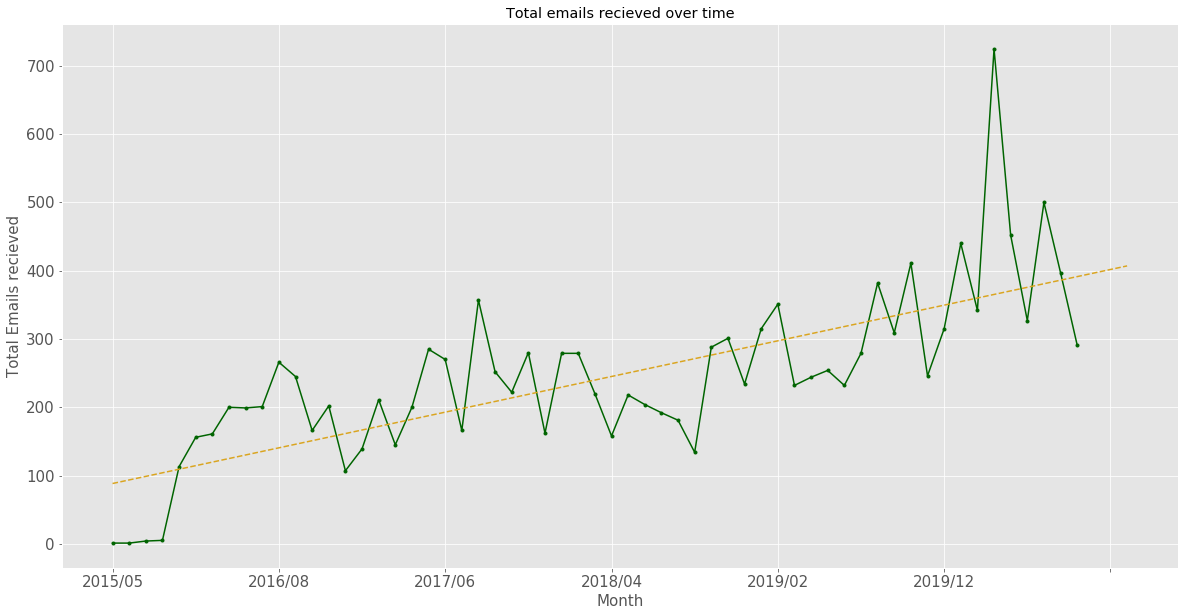

In [7]:
ax = inbox.groupby(["Created"]).count()[1:-2].reset_index().plot(x="Created",y="Subject",
                                                                 legend=False,fontsize=15,marker='.',
                                                                 color="Darkgreen",
                                                                 title="Total emails recieved over time");
plt.plot(x,ypredInbox,"Goldenrod",linestyle = "--");
ax.set_ylabel("Total Emails recieved",fontsize=15);
ax.set_xlabel("Month",fontsize=15);

Here we see the trend of our emails recieved from February of 2016 to April of 2020. We see that there is an upward trend in this data and we can calculate this trend below.

In [8]:
print("Intercept:", np.round(modelInbox.intercept_[0],3))
print("Beta 1:", np.round(modelInbox.coef_[0][0],3))

Intercept: 88.303
Beta 1: 5.226


The line of best fit through the data can be quantified as $\hat{y} = 88.303 + 5.226\hat{x}$. $\beta_1$ is likely affected by the outlier of March 2020.

**Over time, the number of emails recieved by ADV Help has grown at a rate of about 5.23 emails per month, or about 
63 emails per year.**

# Part 2:  

In part 2, we want to examine how many tickets we get in different time periods, whether this be morning vs. afternoon, months, years, or a combination of these things. 

### How can we allocate staff to match our times of highest volume of tickets? 


In [9]:
inboxData = pd.read_csv("InboxData.csv",encoding = 'latin-1')
indexes = inboxData.loc[inboxData["Year"]==2015].index
inboxData = inboxData.drop(indexes)
inboxData = inboxData.reset_index().drop("index",axis=1)

In [10]:
def SelectMetrics(met1, met2, met3):
    if(met3 == "Null"):
        if(met2 == "Null"):
            return inboxData.groupby([met1]).count()["Created"]
        else:
            return inboxData.groupby([met1,met2]).count()["Created"]
    else:
        return inboxData.groupby([met1,met2,met3]).count()["Created"]   

In [11]:
### README:
# SelectMetrics() will return a the inbox dataframe grouped by the columns passed in. for example, 
# SelectMetrics("Date,"AMPM","Null") returns (a sorted Monday - Sunday version of) inbox.groupby(["Date","AMPM"])
# there must be 3 arguemnts passed in, and any unused arguments must be "Null" when passed in.
# Options: "Date","AMPM","Hour","Minute","Month","Day","Year"

toPlot = SelectMetrics("AMPM","Null","Null")
# print the full dataframe

**Methodology**

We can plot emails recieved by time frame with many options, including:


 - "Date": Which weekday - Monday to Sunday - the email was recieved 
<br>
 - "AMPM": If the email was recieved in the morning or afternoon
<br>
 - "Hour": Which hour of the day - 1 to 23 - the email was recieved
<br>
 - "Minute": Which minute - 1 to 60 - of the hour the email was recieved
<br>
 - "Month": Which month - 1 to 12 - the email was recieved
<br>
 - "Day": Which day - 1 to 31 - the email was recieved
<br>
 - "Year": Which year the email was recieved in
<br>

With this information, we can plot something simple like whether we recieve more tickets in the morning or afternoon:

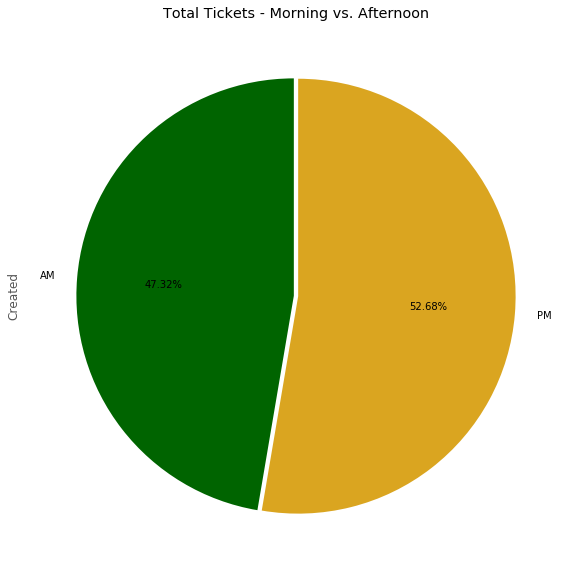

In [12]:
toPlot.plot(kind = "pie",startangle = 90,
            title = "Total Tickets - Morning vs. Afternoon", 
            autopct='%1.2f%%',explode = [0.01,0.01],colors = ["Darkgreen","Goldenrod"]);

and see that in our history, we have recieved more emails after 12:00 PM than before. This could be helpful, but a more in depth version might include weekday in it as well to be more thorough. Including weekday, for example, would look like this:

In [13]:
toPlot = SelectMetrics("Date","AMPM","Null")

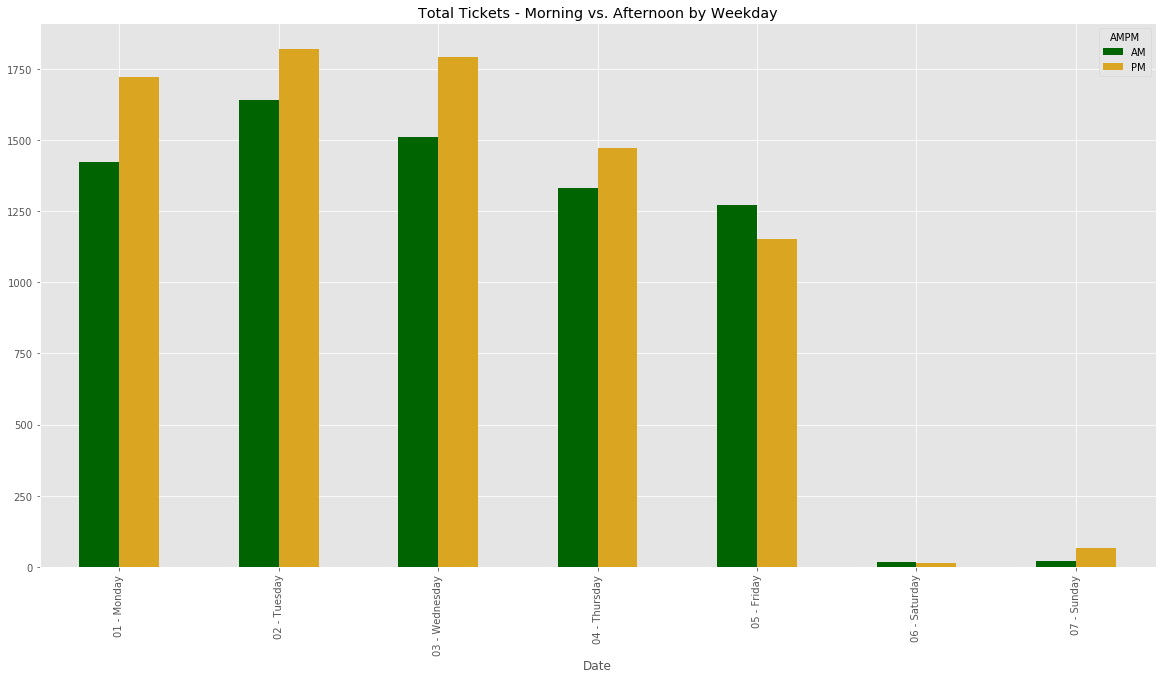

In [14]:
toPlot.unstack().plot.bar(title = "Total Tickets - Morning vs. Afternoon by Weekday",color = ["Darkgreen","Goldenrod"]);

Here we can see that amount of tickets recieved in the afternoon is higher earlier in the week and trends downward as the week goes on. Tuesdays and Wednesdays are our busiest days, while Fridays see the least emails of any weekday. Friday mornings also tend to be busier than friday afternoons, the only day where this is true. Mondays however show the lagest difference between afternoon and morning.

An even more in depth version might ask whether this trend has changed over the last few years. Including year in the plot would look like this:

In [15]:
toPlot = SelectMetrics("Year","Date","AMPM")
#toPlot
# or to print the full dataframe

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(toPlot.unstack())

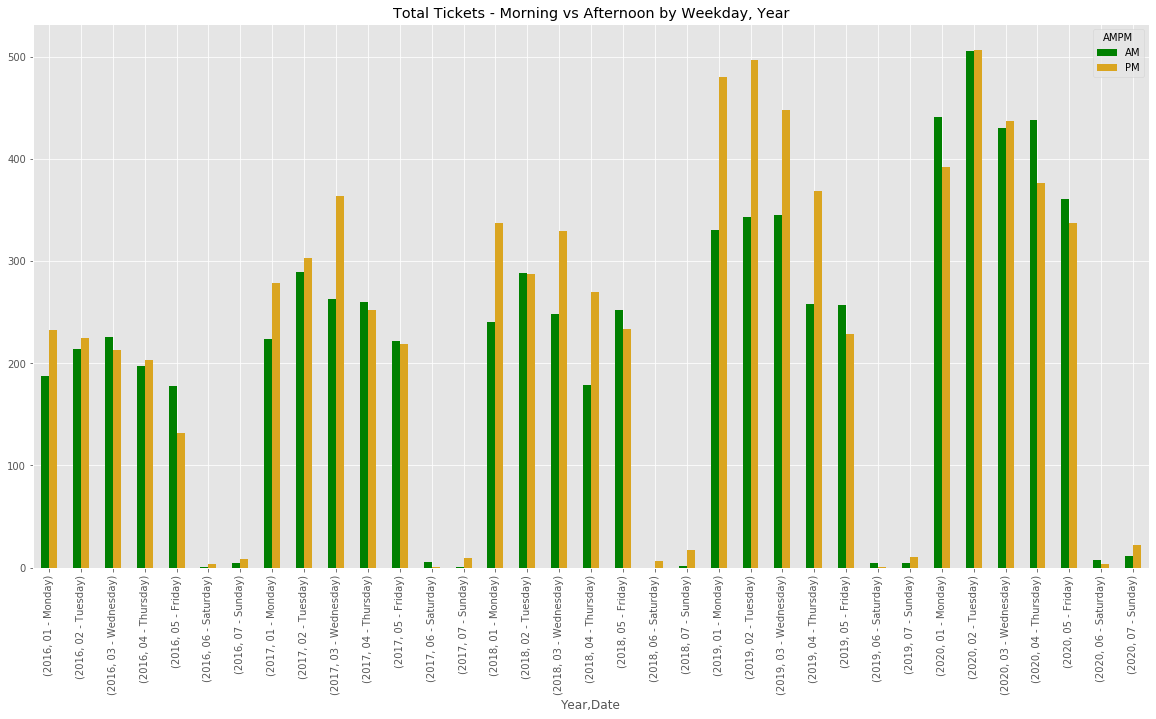

In [16]:
toPlot.unstack().plot.bar(title = "Total Tickets - Morning vs Afternoon by Weekday, Year",color = ["Green","Goldenrod"]);

We can see that although in the past we've recieved more emails in the afternoon, when we plot this for each year the trend shows that this trend is not true for 2020 so far and that we are recieving more emails in the morning this year.

There are many interesting combinations that can give us trends of when we should look out for more emails.

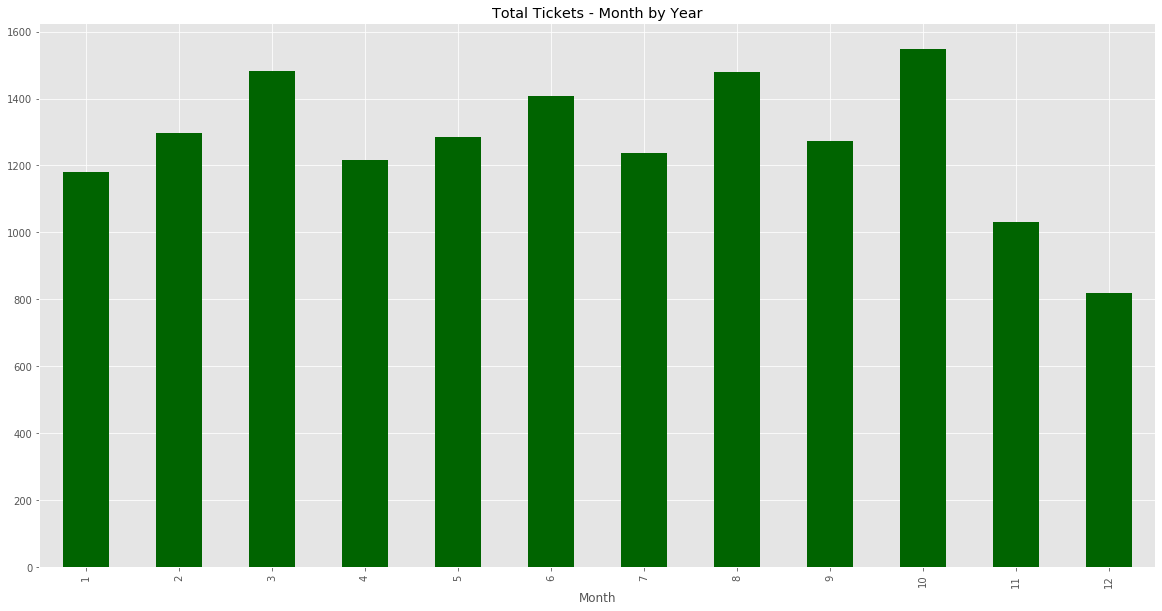

In [17]:
toPlot=SelectMetrics("Month","Null","Null")

toPlot.plot.bar(title = "Total Tickets - Month by Year",color="Darkgreen");

Here, we see that March is our largest month for emails recieved. However, this is misleading, as we see in the plot below.

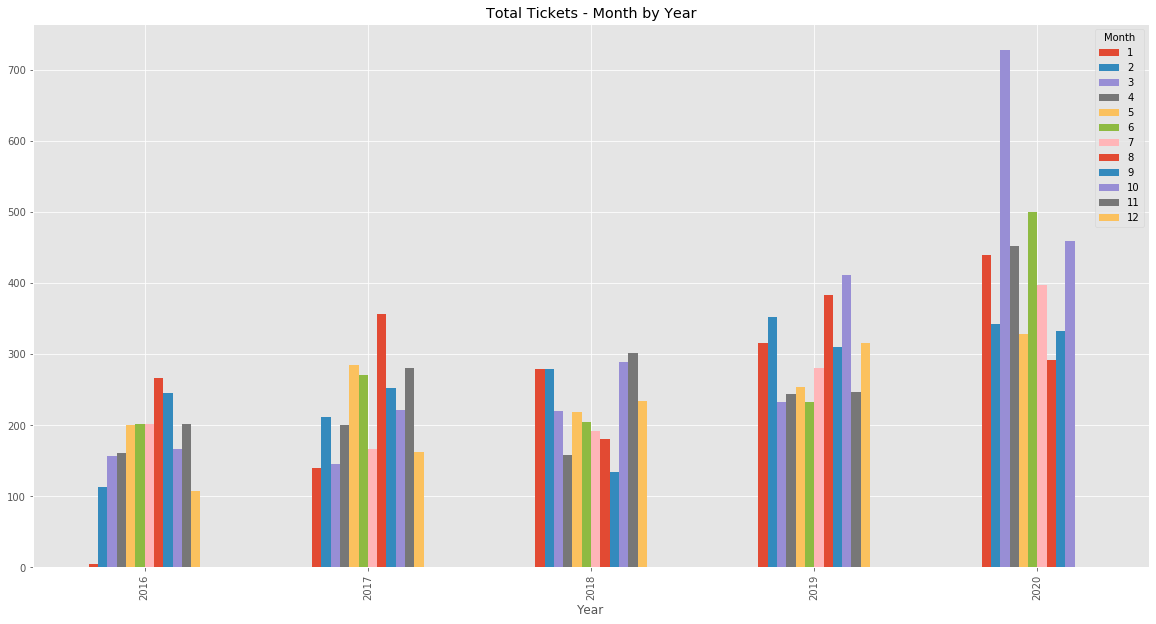

In [18]:
toPlot=SelectMetrics("Year","Month","Null")

toPlot.unstack().plot.bar(title = "Total Tickets - Month by Year");

By organizing the variables this way, we can see trends by year colorized by month. This allows us to see if there are any trends with certain months being more or less busy. If we had just broken this down by month, the data shows March as one of our busiest months, but looking at it this way we can see that apart from the outlier in 2020 the opposite is usually true and March is not generally a large month for us.

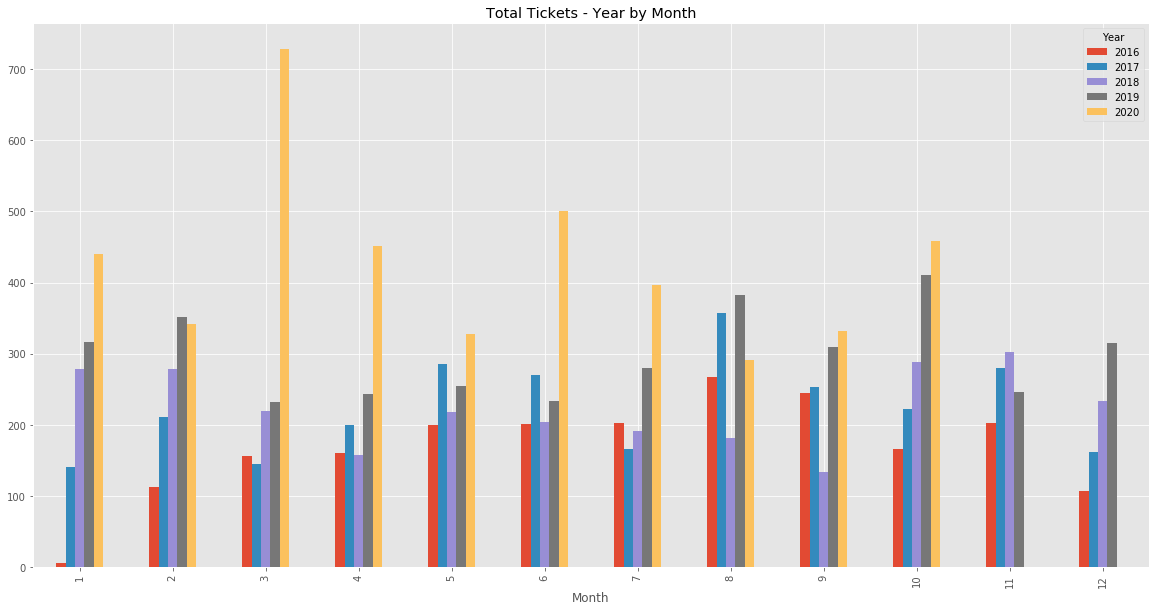

In [19]:
toPlot = SelectMetrics("Month","Year","Null")
toPlot.unstack().plot.bar(title = "Total Tickets - Year by Month");

This plot shows us the inverse of the last plot - each month, colorized by which year the ticket was recieved in. This gives us insight to be able to compare the first few months of a year to previous years or specific months against previous years. We can see here that most months seem to be rising over time, which agrees with our previous insight that we are recieving more and more emails. We can also see that even before lockdown, January and February were shaping up to be as busy or busier than last year, meaning not all of the influx of emails should be attributed to working from home and that we were likely to continue to see growth in the inbox regardless.

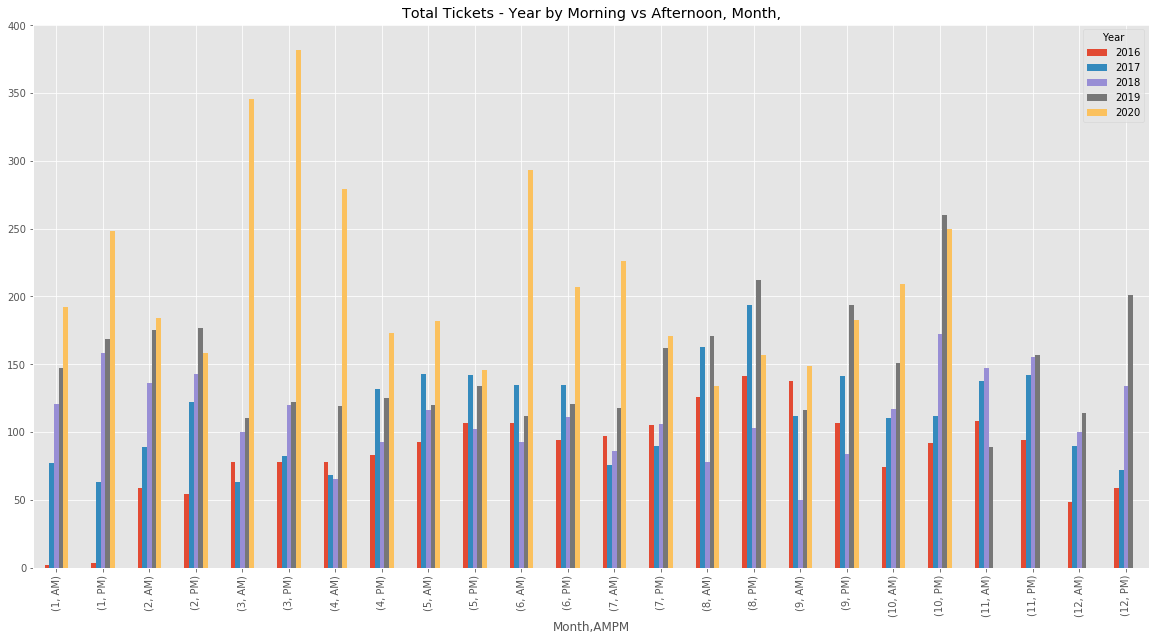

In [20]:
toPlot = SelectMetrics("Month","AMPM","Year")
toPlot.unstack().plot.bar(title = "Total Tickets - Year by Morning vs Afternoon, Month,");

Here we break the last two down further by splitting the groups into Year, morning and afternoon. We can see use this plot to see whether changes over time are consistant between morning and afternoon. We can see that in some months, like October, we have been historically more likely to recieve emails in the afternoon.

More examples of plots with insights are shown below.

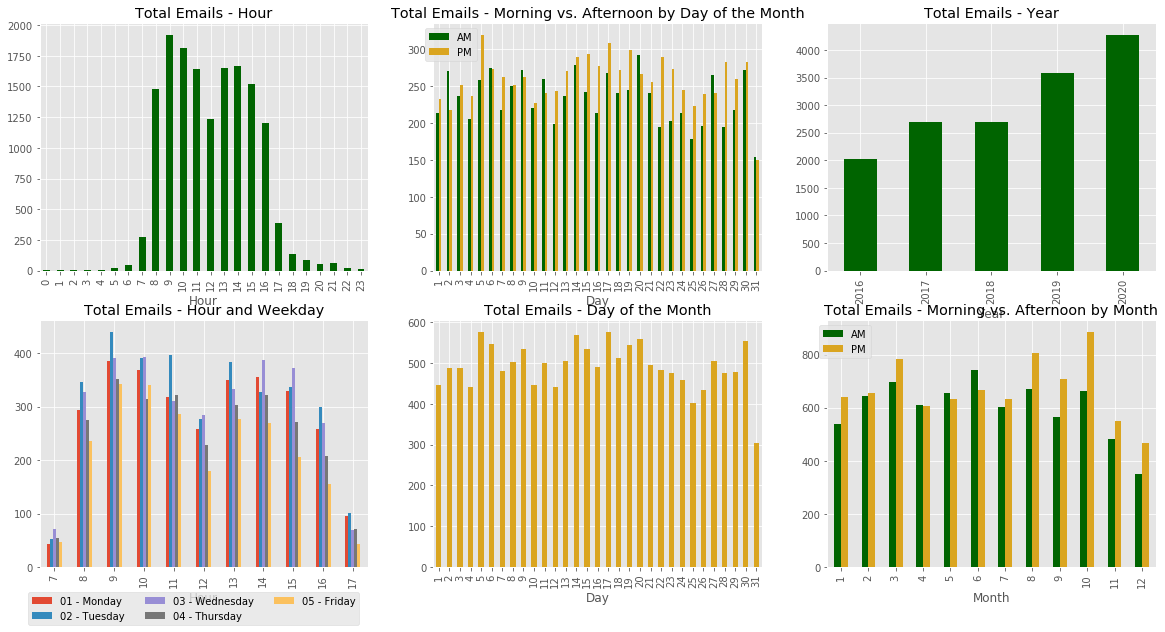

In [61]:
fig, ((ax1, ax2,ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3)

SelectMetrics("Hour","Null","Null").plot.bar(title = "Total Emails - Hour",ax=ax1,legend = 0,color = "Darkgreen");

plot4 = SelectMetrics("Hour","Date","Null").unstack().reset_index() #Plot is crowded originally
plot4 = plot4.drop(["06 - Saturday","07 - Sunday"],axis=1) #Take away Saturday and Sunday
plot4 = plot4.loc[(plot4.Hour > 6) & (plot4.Hour < 18)].set_index("Hour") #Only show hours between 7 and 5
plot4.plot.bar(title = "Total Emails - Hour and Weekday",ax=ax4,legend = 1); #A bit less crowded now
ax4.legend(loc='upper left', bbox_to_anchor=(-.05, -.08), shadow=False, ncol=3);

SelectMetrics("Day","AMPM","Null").unstack().plot.bar(title = "Total Emails - Morning vs. Afternoon by Day of the Month",ax=ax2,legend = 0,color = ["Darkgreen","Goldenrod"]);
ax2.legend(loc='upper left', bbox_to_anchor=(-.04, 1), shadow=False, ncol=1);

SelectMetrics("Day","Null","Null").plot.bar(title = "Total Emails - Day of the Month",ax=ax5,legend = 0, color = "Goldenrod");

SelectMetrics("Year","Null","Null").plot.bar(title = "Total Emails - Year",ax=ax3,legend = 0,color = "Darkgreen");

SelectMetrics("Month","AMPM","Null").unstack().plot.bar(title = "Total Emails - Morning vs. Afternoon by Month",ax=ax6,legend = 1, color = ["Darkgreen","Goldenrod"]);
ax6.legend(loc='upper left', bbox_to_anchor=(-.04, 1), shadow=False, ncol=1);

- **Total Emails - Hour:** We reviece the most emails between 9 and 10 o'clock, followed by between 10 and 11 o'clock and between 2 and 3 o'clock.
- **Total Emails - Hour and Weekday:** The amount of emails we recieve by hour is fairly constant across the day of the week. We see more emails between 9:00 and 12:00 on Tuesdays than any other day, while we see the most emails between 2:00 and 4:00 on Wednesdays.
- **Total Emails - Morning vs. Afternoon by Day of the Month:** We see a similar breakdown to the plot below here, but we can see that we get more emails in the afternoon later in the month than we do earlier in the month.
- **Total Emails - Day of the Month:** We see the most emails on the 5th and 6th of the month, followed by the 30th. We recieve slightly less emails later in the month than earlier in the month, but it's not a very significant difference.
- **Total Emails - Year:** We have looked at this in different ways, but this plot shows us that this year will be our highest emailed year by far.
- **Total Emails = Morning vs. Afternooon by Month:** we see more email in the afternoon in the later months than we do in the first 6 months.

***

There are many more combinations of plots we could create, but the insight drawn from these is valuable. 

To answer our question, we can summarize some **trends of the times of increased and decreased volume:**

- **Afternoons** are typically more busy than mornings. We have recieved almost 53% of our tickets in the afternoon, although that trend has changed this calendar year. In particular, we see our most emails between 9:00 and 11:00 AM and 1:00 and 3:00 PM
<br>

- **Tuesdays and Wednesdays** are our busiest days of the week. Monday afternoons are busy, while mornings have much less volume. Friday is our least busy time, both morning and afternoon. 
<br>

- **Earlier in the Month** tends to be slightly busier than later in the Month.
<br>

- **The Month of the year** in which we recieved the most email does not have much of a constant trend. Generally, **October, August and February** are times of more emails, while **December** is our least-emailed month. 


# Part 3

In this section, we break our inbox down into categories to see if we can find any trends based on the different categories. We look to explore this by different time period like we did in part 2.

## a: What is the category breakdown on incoming tickets?



In [22]:
plt.rcParams["figure.figsize"] = (20,10)
inboxData["Email Categories"] = ""

Using the SortEmails function, we can go through the emails and find subject lines with keywords relating to categories of tickets. The current keywords are as follows:

In [23]:
Email = ["outlook","email","emails","mailbox",'mailboxes','delegate','calendar','gmail','phishing','exchange','spam']
Remote = ["remote","rdp","remote desktop",'pulse','duo','vpn', 'secure',"pulse/vpn"]
Hardware = ["monitor","webcam","webcams","monitors","PC","keyboard","dock","docks","station","setup","mouse","keyboards","PCs","pc","laptops",'keyboard/mouse','mice',"laptop","screen","cable","cord","desktop","desktops",'printer','print','device','devices','tech','computer','computer','TV','TVs','hard drive','hard','hardware','speakers','speaker', 'ink','toner','cartridge',"maintenance","drill","cable management","scanner","scanning","scan"]
Network = ["network drives","network","networking","connection","internet","wifi","domain","permission","permissions",'drive','drives','access','dl','dl:','dl-','dls','distribution','folder','folders','eid','listserv','connection','connections',"internet/Connection"]
Adobe = ["adobe","acrobat","pdf","creative cloud",'creative','photoshop','illustrator','reader']
Software = ["install","tableau","activation","program","download","update","updates","software","installation",'license','licensing','teams','team',"word","excel","powerpoint","onenote","onedrive","zoom","skype"]
Purchasing = ["order","FedEx","Fedex","fedex","UPS","ups","Ups","USPS","usps","Usps","replacement","kuali","shipping","ship","purchasing","purchase", 'transit','subscription','deliver','delivery','price','pricing','prices','membership']
Personnel = ["employee","employees",'student',"hire",'hired',"on-boarding","on-board","welcome",'resignation','departures','supervisor','supervisors']
Phone = ['call','missed','missed call','voice','voicemail','phone','phones']

In [24]:
#Sort the emails into their "Email Category" by keyword above.

def SortEmails(inbox):
    for i in range(0,len(inbox["Subject"].values)):
        for j in str(inbox["Subject"][i]).replace("."," ").split(" "):
            if j.lower() in Email and inbox["Email Categories"][i] == "": #If the Email Categories column is empty
                inbox["Email Categories"][i] = inbox["Email Categories"][i] +  "Email" #Append the keyword first seen in it
            if j.lower() in Remote and inbox["Email Categories"][i] == "":
                inbox["Email Categories"][i] = inbox["Email Categories"][i] +  "Remote"
            if j.lower() in Hardware and inbox["Email Categories"][i] == "":
                inbox["Email Categories"][i] = inbox["Email Categories"][i] +  "Hardware"
            if j.lower() in Network and inbox["Email Categories"][i] == "":
                inbox["Email Categories"][i] = inbox["Email Categories"][i] +  "Network"
            if j.lower() in Adobe and inbox["Email Categories"][i] == "":
                inbox["Email Categories"][i] = inbox["Email Categories"][i] +  "Adobe"
            if j.lower() in Software and inbox["Email Categories"][i] == "":
                inbox["Email Categories"][i] = inbox["Email Categories"][i] +  "Software"
            if j.lower() in Purchasing and inbox["Email Categories"][i] == "":
                inbox["Email Categories"][i] = inbox["Email Categories"][i] +  "Purchasing"
            if j.lower() in Phone and inbox["Email Categories"][i] == "":
                inbox["Email Categories"][i] = inbox["Email Categories"][i] + "Phone"
            if j.lower() in Personnel and inbox["Email Categories"][i]=="":
                inbox["Email Categories"][i] = inbox["Email Categories"][i] + "Personnel"

In [25]:
import warnings
warnings.filterwarnings('ignore')
SortEmails(inboxData);
inbox = inboxData;

Using this function, we can plot Categories by time or against one another by time. For example, below is a plot of Email category tickets vs Hardware category tickets over the last 4 years.

In [26]:
grouped = inbox.groupby(["Email Categories","Created"]).count()["From"].reset_index()
grouped2 = inbox.groupby(["Categories","Email Categories","Created"]).count()["From"].reset_index()
def Plot(var1, var2, var3):
    if(str(var2) == "Null" and str(var3) == "Null"):
        ax = plt.gca()
        grouped.loc[grouped["Email Categories"]==str(var1)].plot(x="Created",y="From",ax=ax)
        ax.legend([var1])
        plt.show()
    elif(str(var3) == "Null"):
        ax = plt.gca()
        grouped.loc[grouped["Email Categories"]==str(var1)].plot(x = "Created",ax=ax)
        grouped.loc[grouped["Email Categories"]==str(var2)].plot(x = "Created",ax=ax)
        ax.legend([var1,var2])
        plt.show()
    else:
        ax = plt.gca()
        grouped.loc[grouped["Email Categories"]==str(var1)].plot(x = "Created",ax=ax,legend=var1)
        grouped.loc[grouped["Email Categories"]==str(var2)].plot(x = "Created",ax=ax)
        grouped.loc[grouped["Email Categories"]==str(var3)].plot(x = "Created",ax=ax)
        ax.legend([var1,var2,var3])
        plt.show()


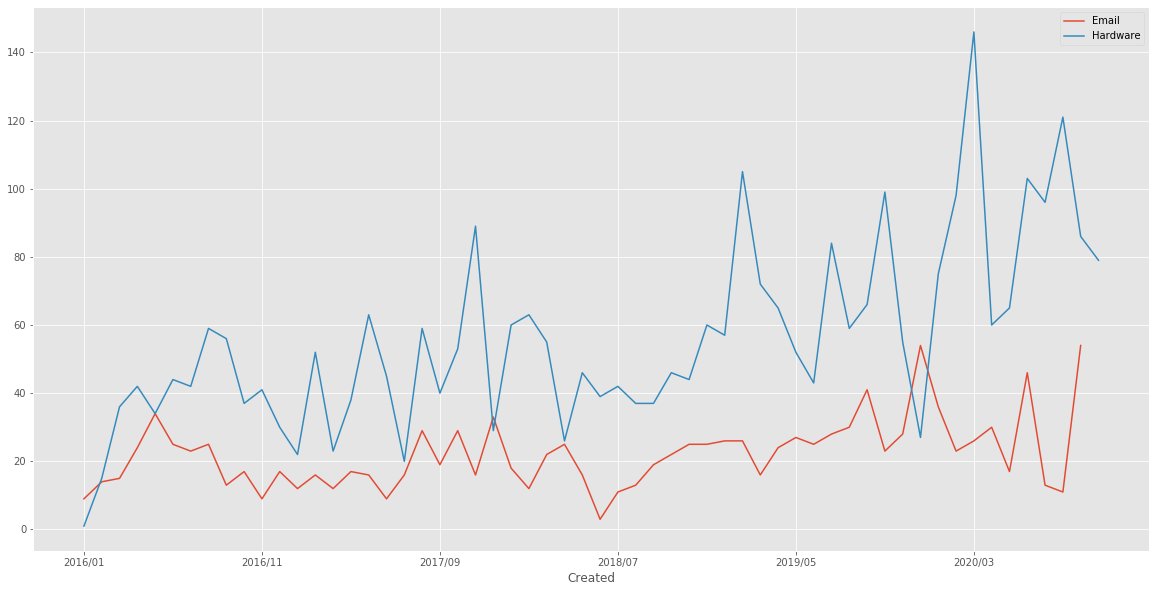

In [27]:
Plot("Email","Hardware","Null")

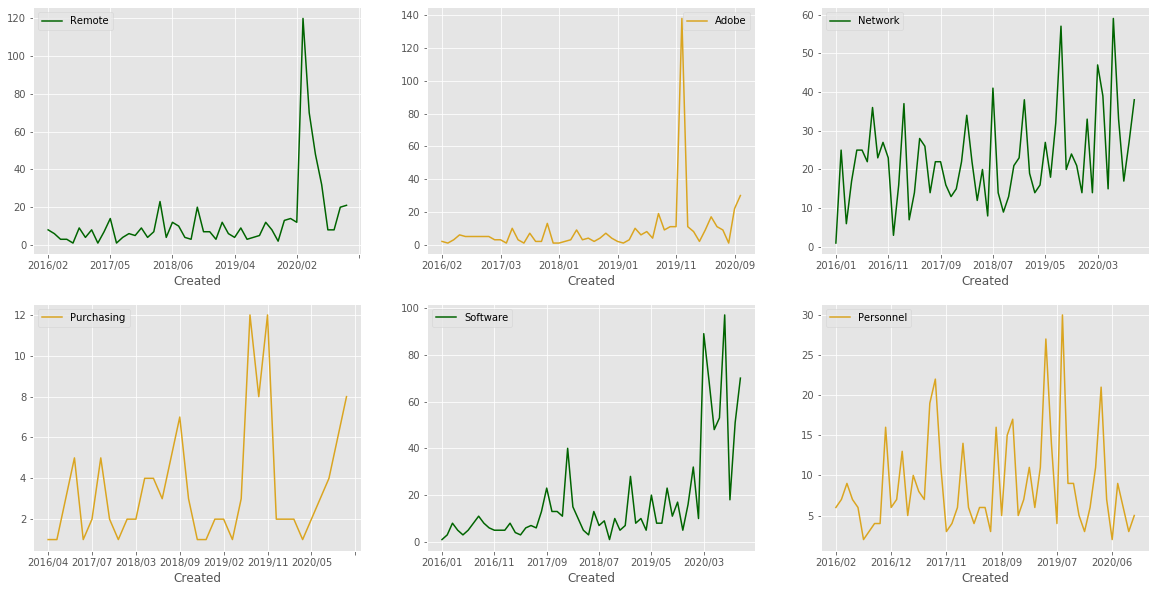

In [28]:
fig, ((ax1, ax2,ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3)


grouped.loc[grouped["Email Categories"]=="Remote"].plot(x="Created",y="From",ax=ax1,color = "Darkgreen")
ax1.legend(["Remote"]);

grouped.loc[grouped["Email Categories"]=="Adobe"].plot(x="Created",y="From",ax=ax2, color = "Goldenrod")
ax2.legend(["Adobe"]);

grouped.loc[grouped["Email Categories"]=="Network"].plot(x="Created",y="From",ax=ax3, color = "Darkgreen")
ax3.legend(["Network"]);

grouped.loc[grouped["Email Categories"]=="Purchasing"].plot(x="Created",y="From",ax=ax4, color = "Goldenrod")
ax4.legend(["Purchasing"]);

grouped.loc[grouped["Email Categories"]=="Software"].plot(x="Created",y="From",ax=ax5, color = "Darkgreen")
ax5.legend(["Software"]);

grouped.loc[grouped["Email Categories"]=="Personnel"].plot(x="Created",y="From",ax=ax6, color = "Goldenrod")
ax6.legend(["Personnel"]);


The rest of the categories are plotted above. We can see that most of them have a spike recently and are generally trending upward. Most of these spikes are easily explainable - for instance, the **Remote** category spikes around March of 2020, when the division was starting to work from home and needed our remote connection guides and software. **Adobe** has a spike in November/December of 2019, the month when the technicians were upgrading all machines to the new Adobe Acrobat 2017.

In [29]:
groupedIn = inbox.groupby(["Categories","Email Categories"]).count()["From"].reset_index()
temp = groupedIn
total = inbox.groupby(["Email Categories"]).count()["From"].reset_index()

total["Total"] = total.sum(axis=0)["From"]
total["Percentage"] = np.round(total["From"]/total["Total"],3)*100
total = total.set_index("Email Categories")


The breakdown of total emails by subject can be seen below.

In [30]:
total

,From,Total,Percentage
Email Categories,,,
,5601,15251,36.7
Adobe,464,15251,3.0
Email,1264,15251,8.3
Hardware,3238,15251,21.2
Network,1324,15251,8.7
Personnel,488,15251,3.2
Phone,1124,15251,7.4
Purchasing,123,15251,0.8
Remote,624,15251,4.1


## b: What is does this breakdown look like by time period?

We might want to know if there are any trends of categoriezed tickets to know if we see more errors or slowness at any times in specific.

In [57]:
def GroupCategories(met1,met2,met3):
    if(met2 == "Null"):
        return inbox.groupby(["Email Categories",met1]).count()["From"]
    elif((met2 != "Null") & (met3 == "Null")):
        return inbox.groupby(["Email Categories",met1,met2]).count()["From"]
    elif((met1 != "Null") & (met2 != "Null") & (met3 != "Null")):
        return inbox.groupby(["Email Categories",met1,met2,met3]).count()["From"]
    
def PlotCategories(cat1, met1, met2, met3,title1):
    if(met2 == "Null"):
        temp = inbox.groupby(["Email Categories",met1]).count()["From"].reset_index()
        temp = temp.loc[temp["Email Categories"] == cat1]
        temp = temp.set_index(["Email Categories"])
        temp.plot.bar(x=met1, title=title1, color = "Darkgreen")
    elif((met2 != "Null") & (met3 == "Null") & (met2 == "AMPM")):
        temp = inbox.groupby(["Email Categories",met1,met2]).count()["From"].reset_index()
        temp = temp.loc[temp["Email Categories"] == cat1]
        temp = temp.set_index(["Email Categories",met1,met2]).unstack()
        temp.plot.bar(title=title1, color = ["Darkgreen","Goldenrod"])
    elif((met2 != "Null") & (met3 == "Null") & (met2 != "AMPM")):
        temp = inbox.groupby(["Email Categories",met1,met2]).count()["From"].reset_index()
        temp = temp.loc[temp["Email Categories"] == cat1]
        temp = temp.set_index(["Email Categories",met1,met2]).unstack()
        temp.plot.bar(title=title1)
    elif((met1 != "Null") & (met2 != "Null") & (met3 != "Null")):
        temp = inbox.groupby(["Email Categories",met1,met2,met3]).count()["From"].reset_index()
        temp = temp.loc[temp["Email Categories"] == cat1]
        temp = temp.set_index(["Email Categories",met1,met3,met2])
        temp.unstack().plot.bar(title=title1)


def PlotManyCategories(cat1, met1, met2, met3):
    if(met2 == "Null"):
        temp = inbox.groupby(["Email Categories",met1]).count()["From"].reset_index()
        temp = temp.loc[temp["Email Categories"] == cat1]
        temp = temp.set_index(["Email Categories"])
        return temp
    elif((met2 != "Null") & (met3 == "Null")):
        temp = inbox.groupby(["Email Categories",met1,met2]).count()["From"].reset_index()
        temp = temp.loc[temp["Email Categories"] == cat1]
        temp = temp.set_index(["Email Categories",met1,met2]).unstack()
        return temp
    elif((met1 != "Null") & (met2 != "Null") & (met3 != "Null")):
        temp = inbox.groupby(["Email Categories",met1,met2,met3]).count()["From"].reset_index()
        temp = temp.loc[temp["Email Categories"] == cat1]
        temp = temp.set_index(["Email Categories",met1,met3,met2])
        temp = temp.unstack()
        return temp
##Used for plotting subplots. We can't specify axes in the above function, so this ones allows us to customize axes,
##color, etc.

Our Group Categories and Plot Categories functions can give us the same insight as we recieved above, but this time broken down into categories so we can see when we are recieving the most of a certain type of category in a more detailed way than just over each month like above.

In [58]:
GroupedByTime = GroupCategories("Date","Null","Null")

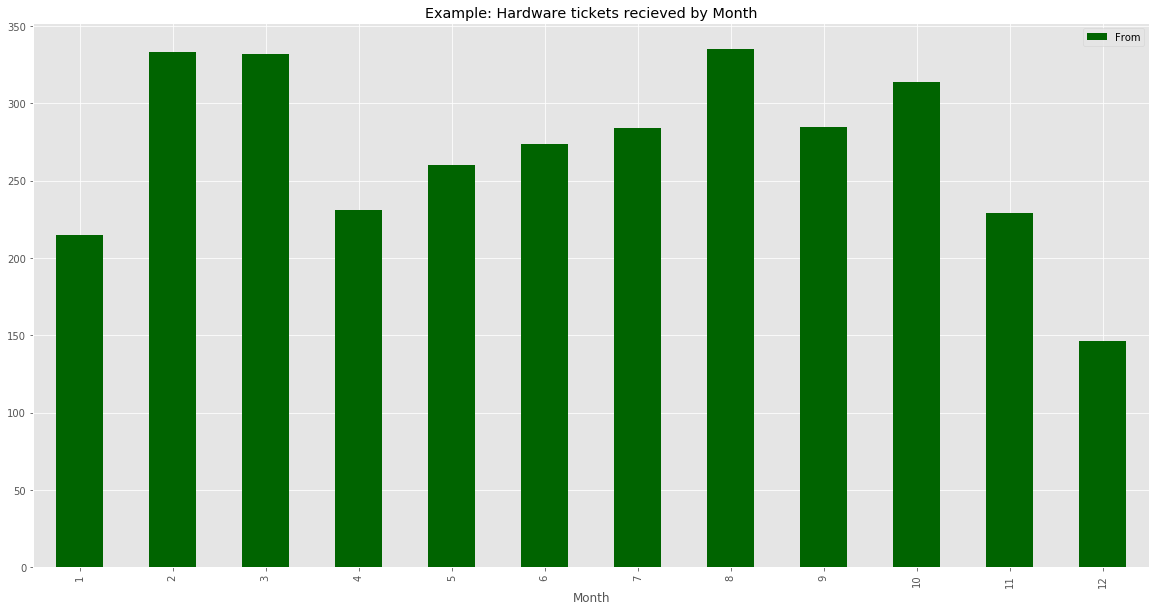

In [59]:
# PlotCategories basic format: ("Category 1","Metric 1","Metric 2","Metric 3")

PlotCategories("Hardware","Month","Null","Null","Example: Hardware tickets recieved by Month")

For example, here we see the **Hardware** category broken down by month. Again, this may not be as insightful as we'd like and we might have a bit of a bias toward March and April due to the large spike of emails in that time period of 2020. We can break this down further to get a better idea of this category's time distribution.

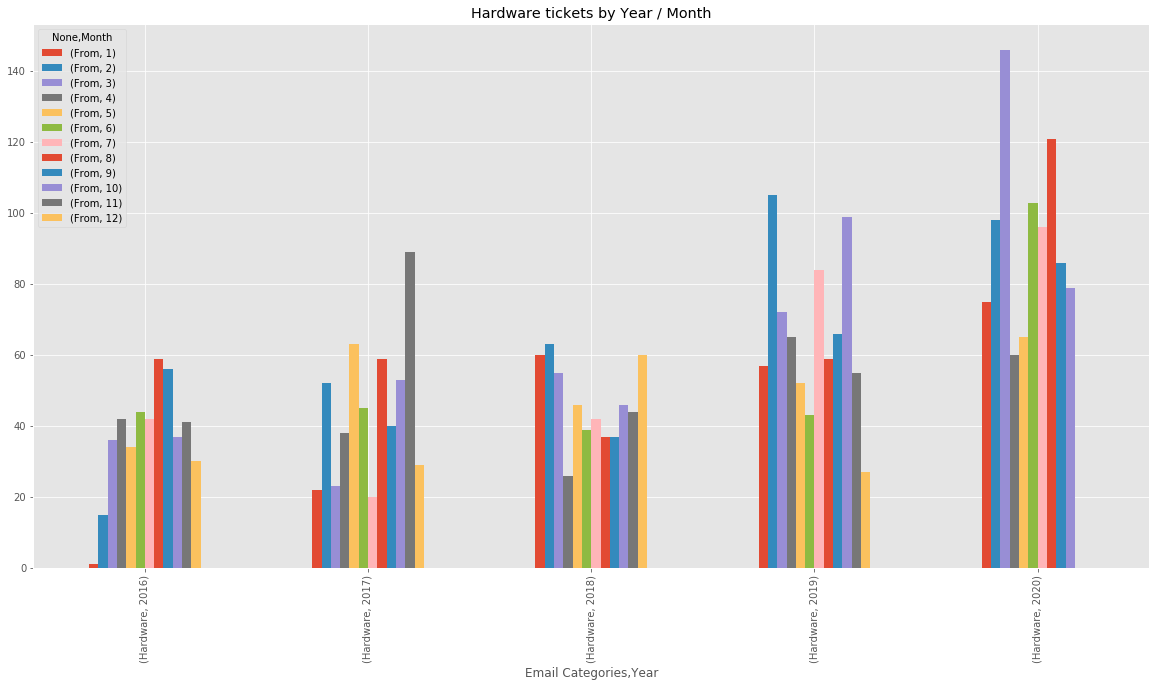

In [60]:
PlotCategories("Hardware","Year","Month","Null","Hardware tickets by Year / Month")

We see here that we are correct - There  was a big spike in February and March of 2020. We could, however, argue whether the February spike was out of the ordinary based on the fact that **we seem to see many Hardware tickets in February each year. We also seem to see spikes in October/November**.

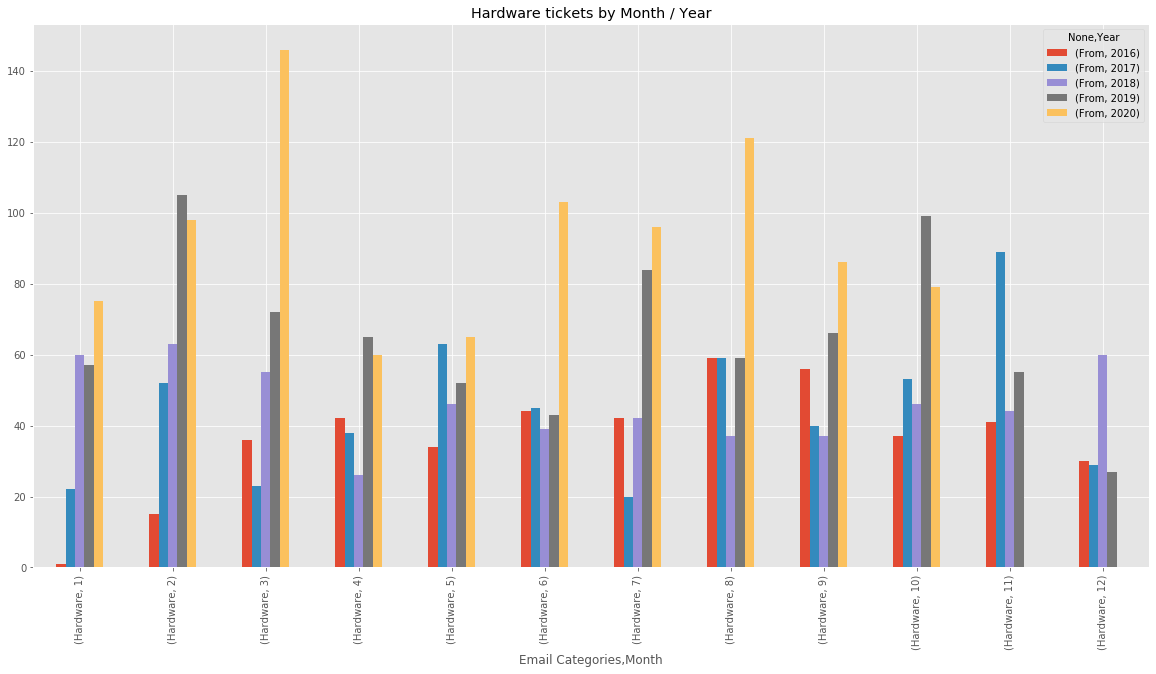

In [35]:
PlotCategories("Hardware","Month","Year","Null","Hardware tickets by Month / Year")

The first plot breaks down each year by month so we can see trends by month inside each year, while the second breaks down each month by year to see how our number of emails recieved in each month have grown or shrunk by year. This gives us the insight that **like emails in general and most categories of emails, Hardware tickets are rising farly consistantly by year**.

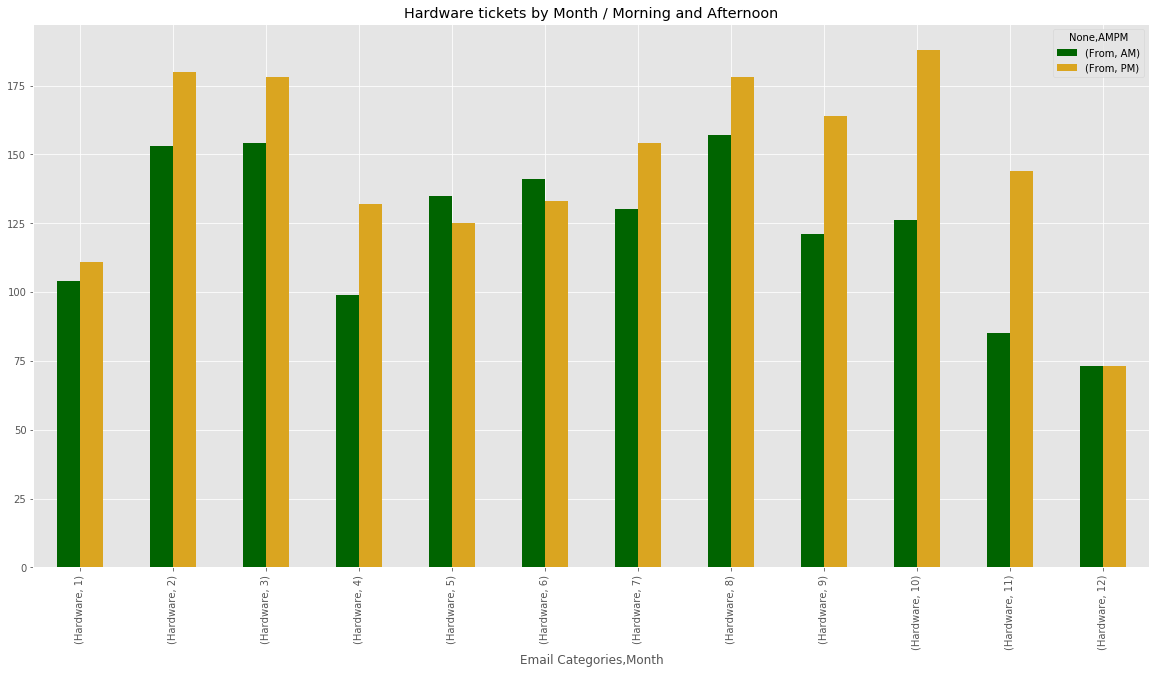

In [36]:
PlotCategories("Hardware","Month","AMPM","Null","Hardware tickets by Month / Morning and Afternoon")

This plot tells us that **certain months, such as October and November, and  have generally had a larger discrepency between the morning and evening emails.** 

So to answer the question "does Outlook run slower on Monday mornings?", we can do the following:

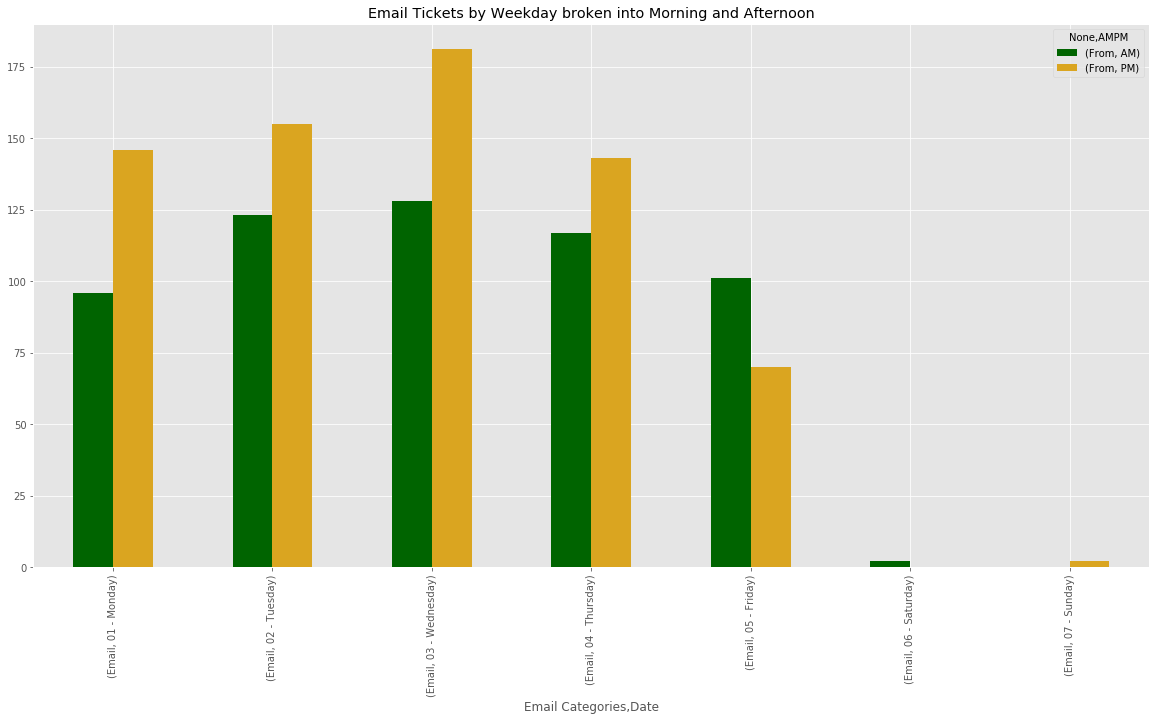

In [38]:
PlotCategories("Email","Date","AMPM","Null","Email Tickets by Weekday broken into Morning and Afternoon")

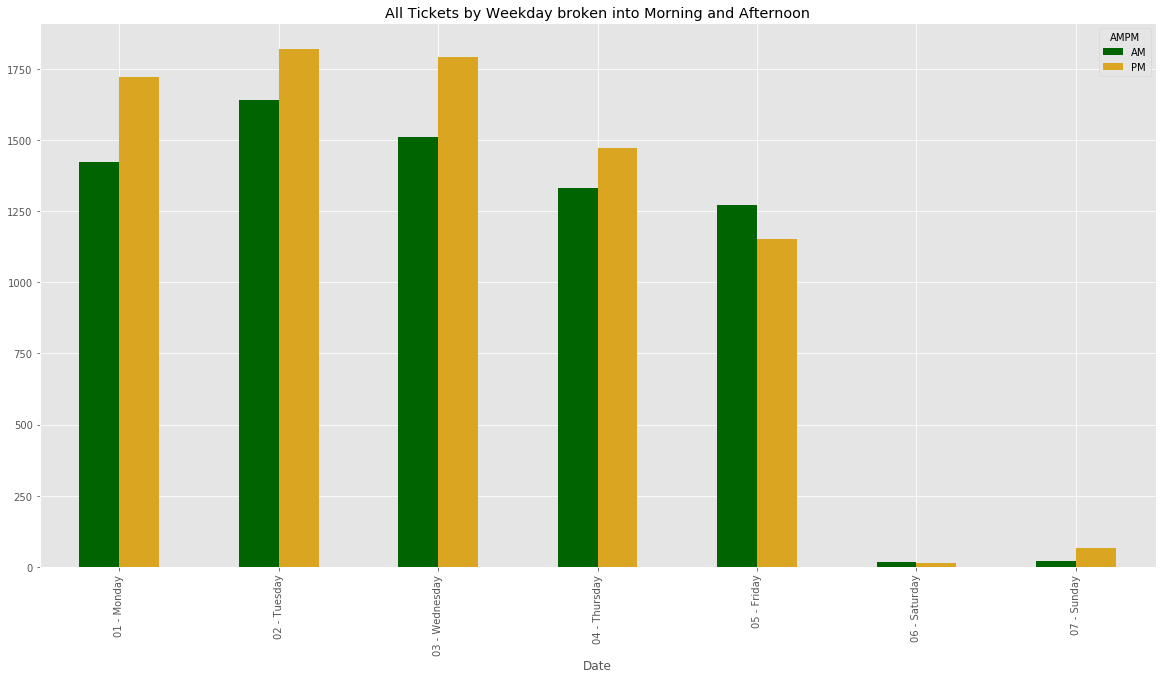

In [39]:
toPlot = SelectMetrics("Date","AMPM","Null")
toPlot.unstack().plot.bar(title = "All Tickets by Weekday broken into Morning and Afternoon", 
                          color = ["Darkgreen","Goldenrod"]);

and conclude that actually, we get email tickets at almost the exact same distribution as we get all tickets, with a slight tilt toward Wednesday afternoons. (Keep in mind that we can only make an inference as far as the ticketing system goes. If someone doesn't email us to tell us that their Outlook is slow, that trend obviously won't show in the plots.)

However, with remote tickets:

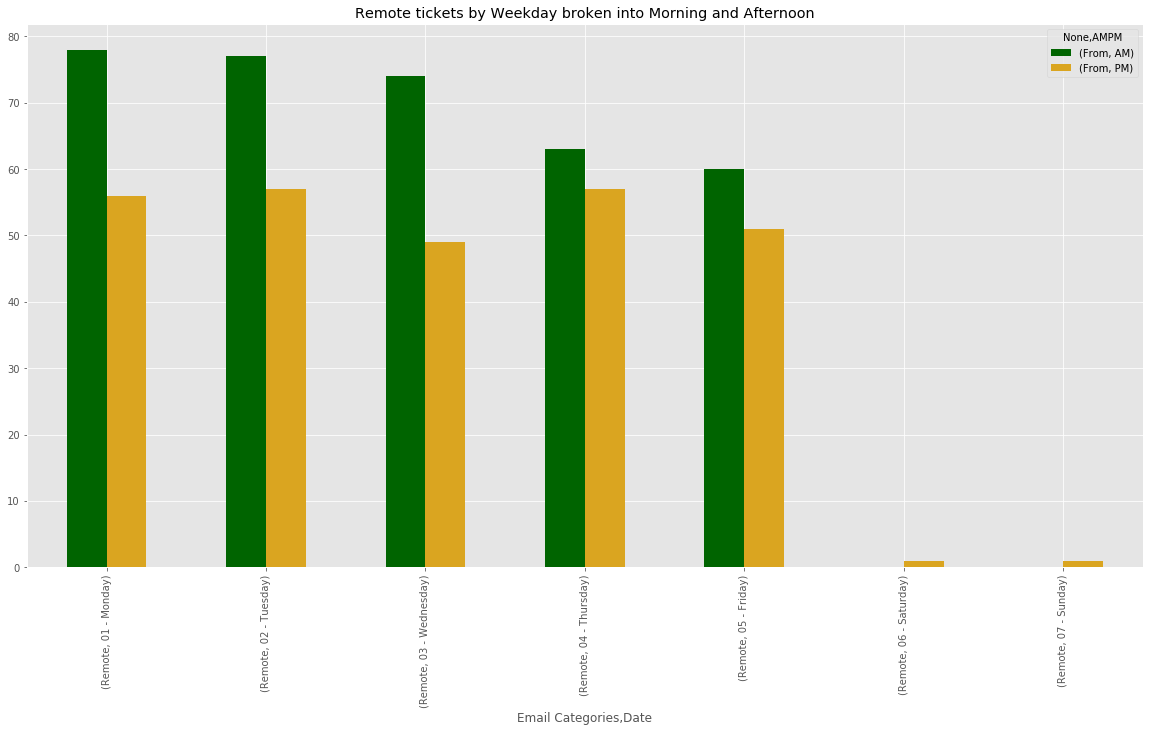

In [40]:
PlotCategories("Remote","Date","AMPM","Null","Remote tickets by Weekday broken into Morning and Afternoon")

We see that we get a lot more tickets in the mornings than we do in the afternoons, which could help us be more on the lookout for these tickets in the mornings. We can see that this trend is also heavily influenced by 2020.

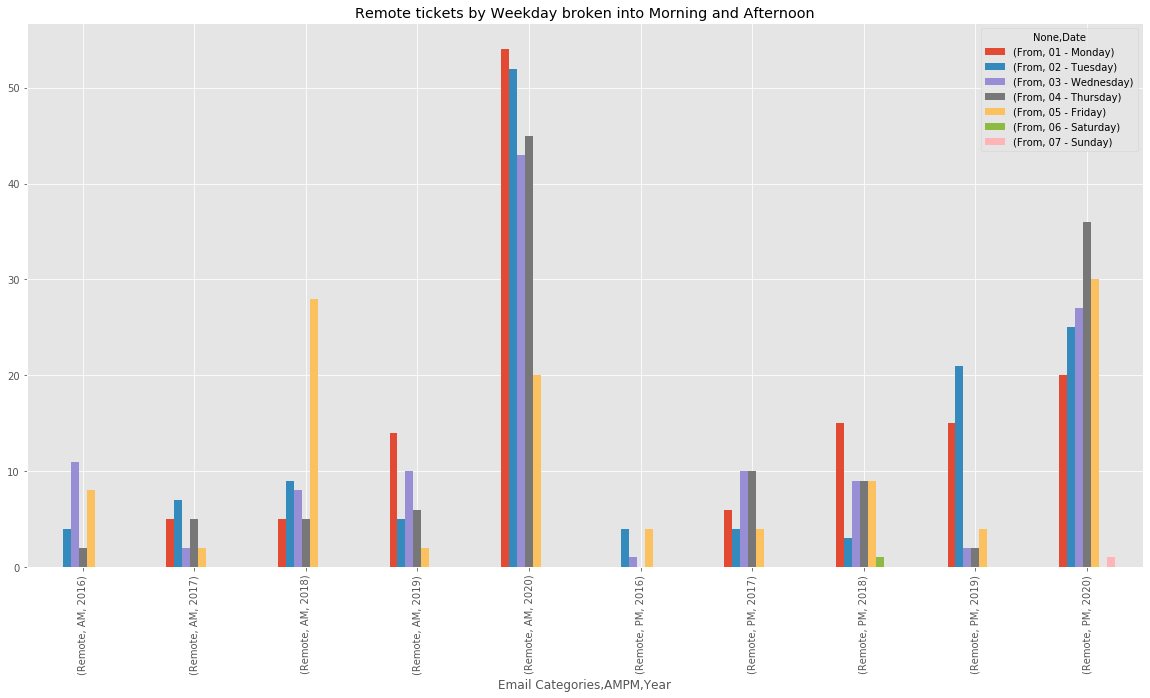

In [41]:
PlotCategories("Remote","AMPM","Date","Year","Remote tickets by Weekday broken into Morning and Afternoon")

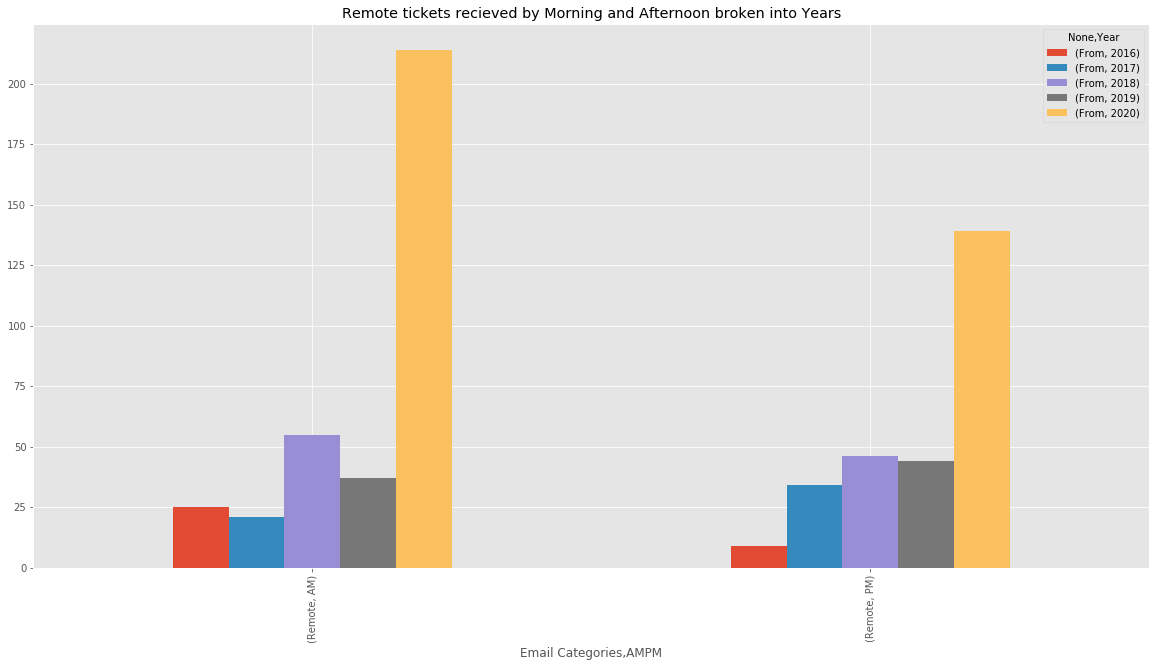

In [42]:
PlotCategories("Remote","AMPM","Year","Null","Remote tickets recieved by Morning and Afternoon broken into Years")

Going through the plots and searching for interesting and/or unexpected trends yeilded the insights explored in the plots below.

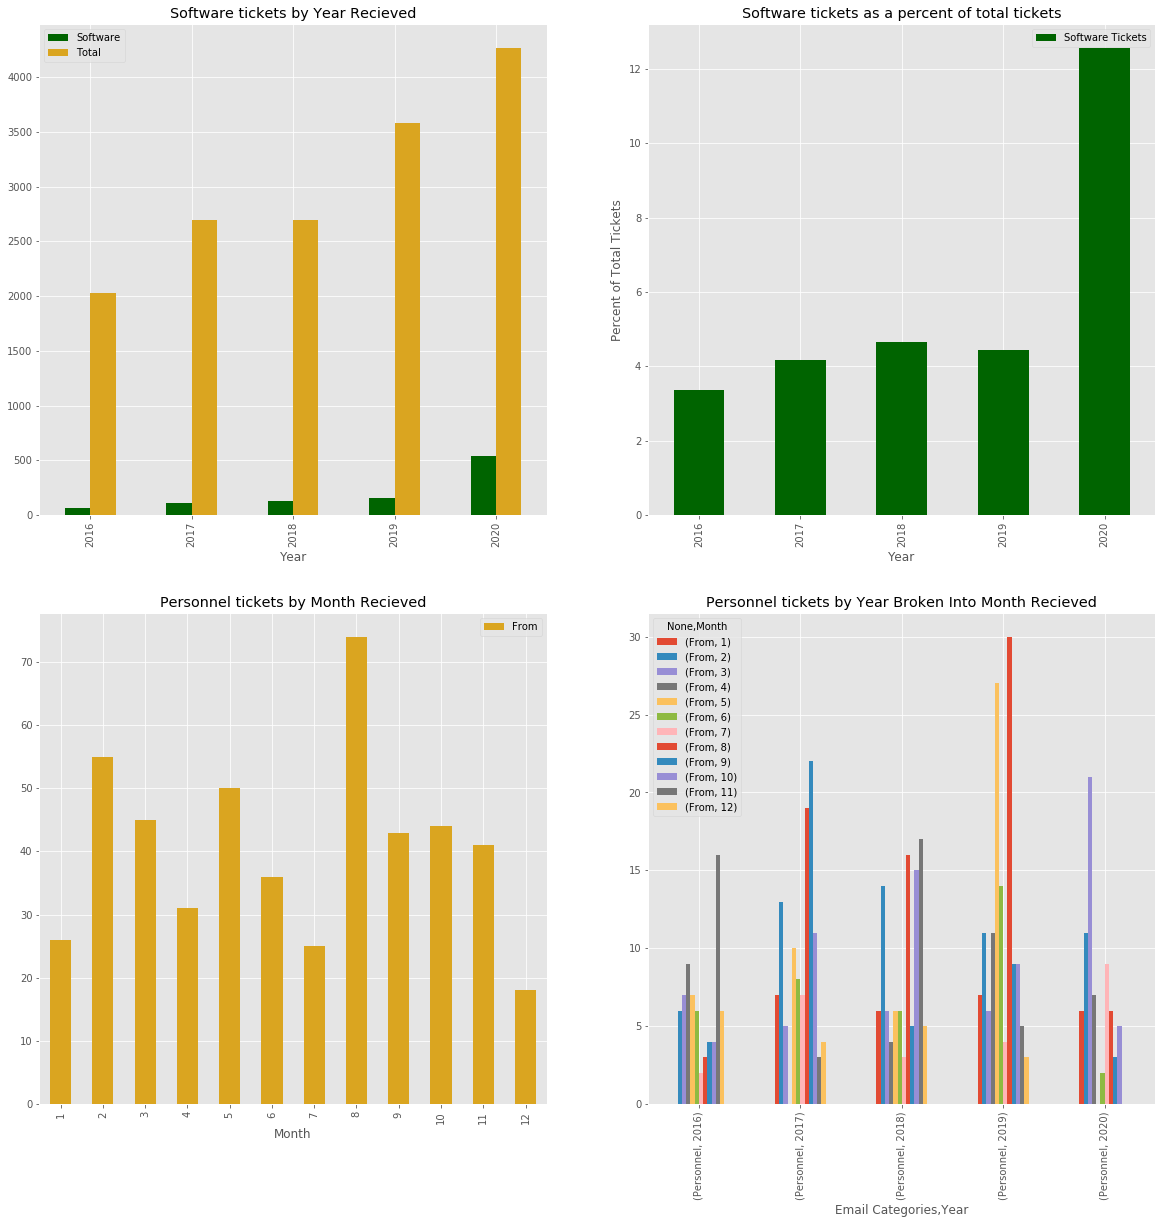

In [43]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2)


plot1a = PlotManyCategories("Software","Year","Null","Null").reset_index().drop(columns=["Email Categories"]);
plot1b = SelectMetrics("Year","Null","Null").reset_index();
plot1b.columns=["Year2","Total"]
plot1 = pd.concat([plot1a,plot1b],axis=1).drop("Year2",axis=1)
plot1.plot.bar(x="Year",y=["From","Total"],title="Software tickets by Year Recieved", ax = ax1, color = ["Darkgreen","Goldenrod"]);
ax1.legend(["Software","Total"])

plot2 = plot1.copy()
plot2["Percentage"] = plot1.From / plot1.Total * 100
plot2.plot.bar(x="Year",y="Percentage",ax = ax2,color="Darkgreen", title = "Software tickets as a percent of total tickets")
ax2.legend(["Software Tickets"])
ax2.set_ylabel("Percent of Total Tickets")

plot3 = PlotManyCategories("Personnel","Year","Month","Null");
plot3.plot.bar(title="Personnel tickets by Year Broken Into Month Recieved",ax = ax4);

plot4 = PlotManyCategories("Personnel","Month","Null","Null");
plot4.plot.bar(title="Personnel tickets by Month Recieved", x = "Month",ax = ax3, color = "Goldenrod");


fig.subplots_adjust(left=None, bottom=2, right=None, top=3.5, wspace=None, hspace=.2)


- **Software Tickets**: Plotting software tickets vs total tickets by year recieved, we can see that **software tickets**, tickets including keywords such as "download", "update", "software", "installation", and "licensing", **seem to be growing at a faster rate than our tickets overall**. As a total percentage of our tickets, software tickets are also growing year-by-year with a spike in 2020.


- **Personnel tickets**: **We see that we get a spike in personnel tickets,** tickets including keywords such as "Hire", "On-boarding", "Welcome", and "Resignation", **in August**. Looking at the plot of Personnel tickets by year broken into month recieved, we can wee that **this spike in August/September is farily consistant over at least the last three years,** so this spike is fairly reliable.

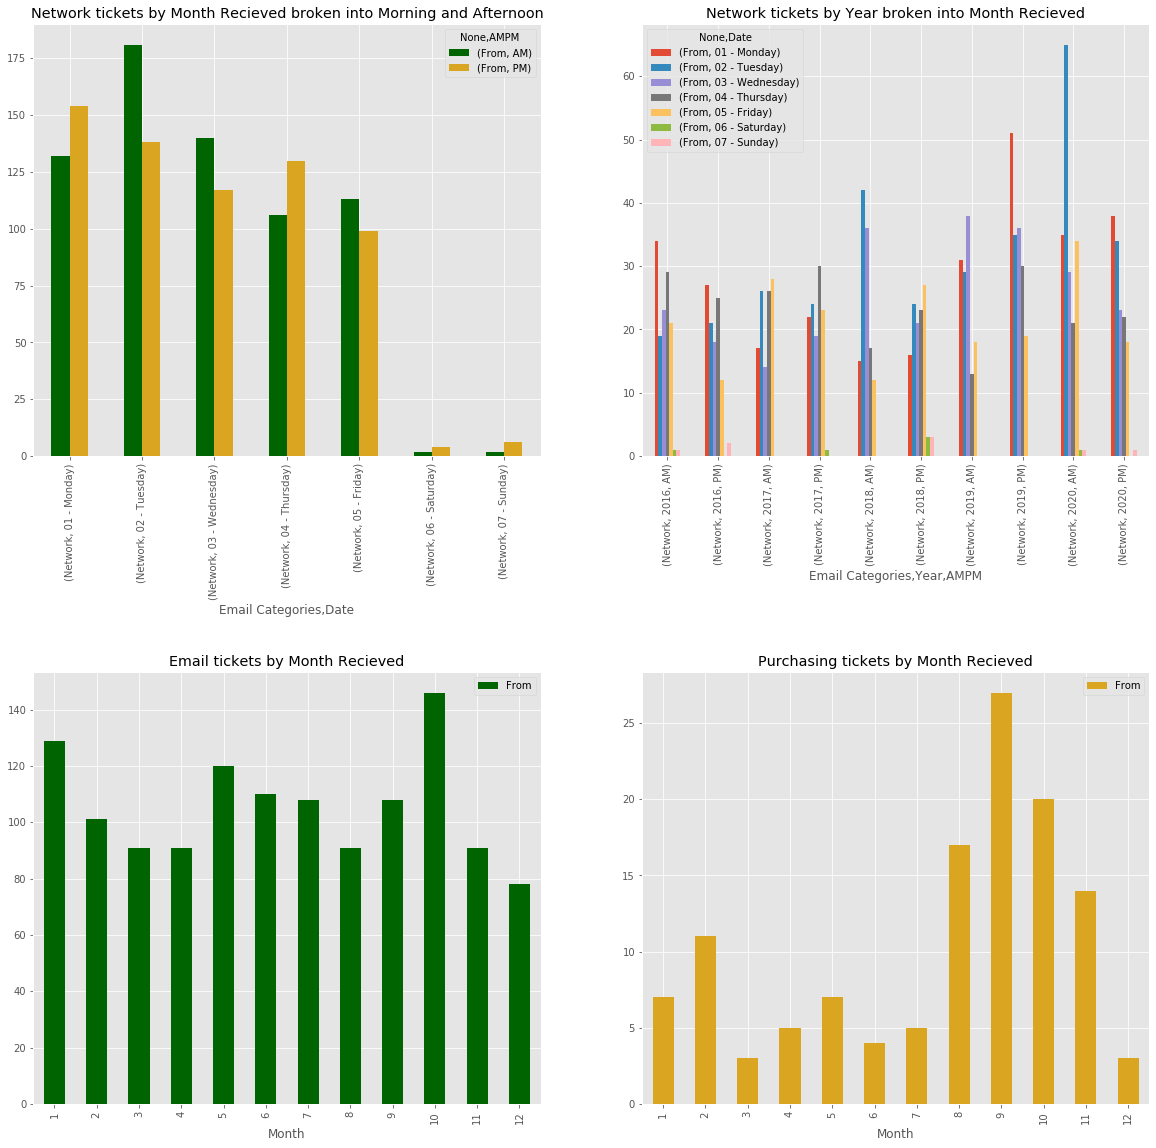

In [63]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2)

plot1 = PlotManyCategories("Network","Date","AMPM","Null");
plot1.plot.bar(title="Network tickets by Month Recieved broken into Morning and Afternoon", ax = ax1, color=['Darkgreen','Goldenrod']);

plot2 = PlotManyCategories("Network","Year","Date","AMPM");
plot2.plot.bar(title="Network tickets by Year broken into Month Recieved", ax = ax2);

plot3 = PlotManyCategories("Email","Month","Null","Null");
plot3.plot.bar(title="Email tickets by Month Recieved",x="Month",ax = ax3, color = "Darkgreen");

plot4 = PlotManyCategories("Purchasing","Month","Null","Null");
plot4.plot.bar(title="Purchasing tickets by Month Recieved",x="Month",color="Goldenrod",ax = ax4);


fig.subplots_adjust(left=None, bottom=2, right=None, top=3.5, wspace=None, hspace=.5)

- **We see the most network tickets on Tuesday mornings**. It is not out of the ordinary to see an increase in tickets on Tuesdays, but we know that mornings are generally less busy than afternoons.

- **Email tickets by month recieved:** By breaking down our "email" tickets, tickets with keywords like "Outlook", "Mailbox", and "Email", we can see that we see our largest spike in January. This may be an interesting trend to look into as it counters our findings above that January is generally not a time of large email volume.
- **Purchasing tickets by month recieved**: Our purchasing tickets, tickets with keywords such as "order", "purchase", "replacement", or "delivery", sees by far its largest spike in September. 

***




# Part 4: 

In part 4, we want to answer questions about the breakdown of our total tickets in each category. We can use this information to inform descisions about what tickets to devote the most resources to, how we should train employees, and more.

## a: What is the breakdown of tickets completed by category? 


We now have a breakdown of what tickets we recieve the most of and when, which can be useful to know what kind of tickets we should devote the most resources to. It might also be interesting to see what kind of tickets we complete at the highest rate to see if we struggle in some categories more than others. Note that these percentages lean on the side of too high due to tickets marked Done twice. 

In [45]:
#doneGrouped is a dataFrame that takes all tickets with "Done" in the categories and groups it by category, then 
# breaks it down like the other inboxes above.
doneGrouped = groupedIn.loc[groupedIn.Categories.str.contains("Done")].groupby("Email Categories").sum()
doneGrouped["Total"] = doneGrouped.sum(axis=0)["From"]
doneGrouped["Percentage"] = np.round(doneGrouped["From"]/doneGrouped["Total"],3)*100

In [46]:
#same idea as above
noRe = inbox[(inbox.Subject.str.contains("RE:",na=False)==False) & 
             (inbox.Subject.str.contains("Re:",na=False)==False)]
noReGrouped = noRe.groupby("Email Categories").count()["From"].reset_index()
noReGrouped["Total"] = noReGrouped.sum(axis=0)["From"]
noReGrouped["Percentage"] = np.round(noReGrouped["From"]/noReGrouped["Total"],3)*100

In [47]:
print("Completed Tickets:\n",doneGrouped)
print("\n\n")
print("Total Tickets:\n",total)

Completed Tickets:
                   From  Total  Percentage
Email Categories                         
                  2277   6766        33.7
Adobe              223   6766         3.3
Email              632   6766         9.3
Hardware          1443   6766        21.3
Network            657   6766         9.7
Personnel          274   6766         4.0
Phone              568   6766         8.4
Purchasing          58   6766         0.9
Remote             238   6766         3.5
Software           396   6766         5.9



Total Tickets:
                   From  Total  Percentage
Email Categories                         
                  5601  15251        36.7
Adobe              464  15251         3.0
Email             1264  15251         8.3
Hardware          3238  15251        21.2
Network           1324  15251         8.7
Personnel          488  15251         3.2
Phone             1124  15251         7.4
Purchasing         123  15251         0.8
Remote             624  15251        

We add some noise to the Completed tickets group to account for the lower percentage of Uncategorized tickets and plot the two data frames side-by-side.

In [48]:
doneGrouped["Percentage"] = doneGrouped["Percentage"] * .9 # the Ungrouped are 10% lower in the completed dataframe so 
                                                            # we lower each column by the same

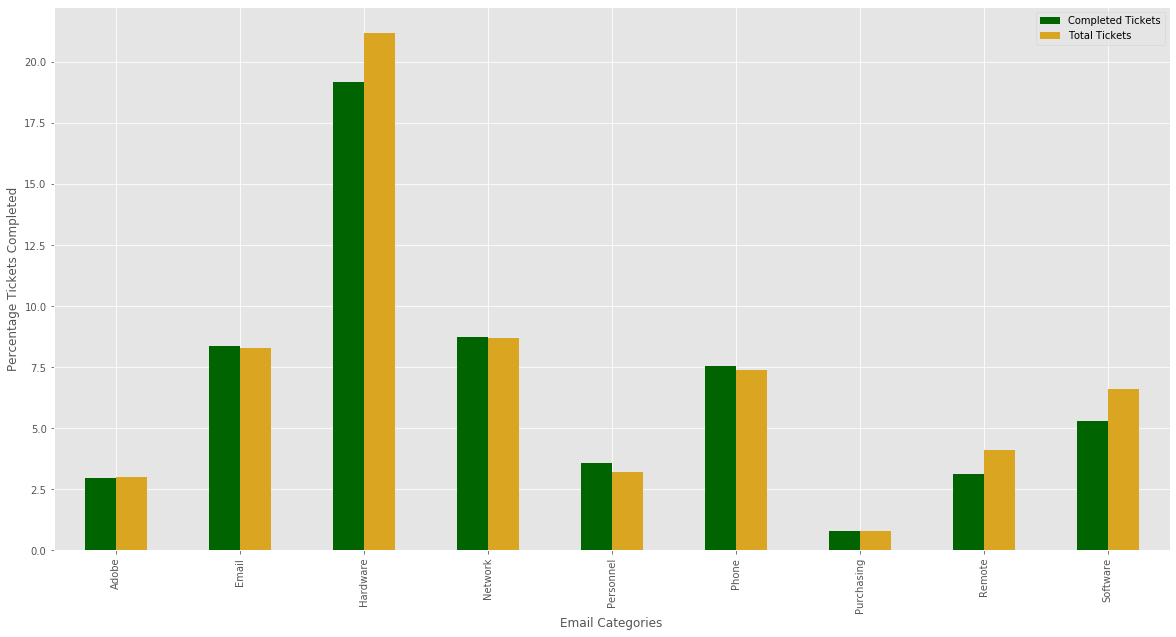

In [49]:
new = pd.concat([doneGrouped, total],axis = 1);
new = new.drop("",axis=0);
ax = new.plot.bar(y = "Percentage", color = ["Darkgreen","Goldenrod"]);
ax.set_ylabel("Percentage Tickets Completed");
ax.legend(["Completed Tickets","Total Tickets"]);

We can see that our numbers follow pretty closely, and with the inaccuracy of the done tickets we can say that most of the percentages are likely very close to each other without duplicates. The interesting columns then are the ones that have lower or very close percentages in the Done data frame. These are **Hardware, Remote, and Software.** If our data is accurate, this would mean that **these are the tickets that go uncompleted most often**. This could be something to look out for in the future.

## b: By technician?

In [50]:
ethan = temp.loc[temp["Categories"] == "Done - Ethan"]
ethan["Total"] = ethan.sum(axis=0)["From"]
ethan["Percentage"] = np.round(ethan["From"]/ethan["Total"],3)*100

Dividing the tickets by technician, we can compare what kind of tickets a technician responds to most vs what kind of tickets we recieve the most to see if our technicians have any obvious gaps in the type of tickets they respond to. For instance, here are the number of tickets I've completed (those marked as Done - Ethan) vs the total numbers.

In [51]:
print("Tickets completed by Ethan:\n",ethan[["Email Categories","From","Total","Percentage"]])
print("\n")
print("Total Tickets completed\n",total)

Tickets completed by Ethan:
    Email Categories  From  Total  Percentage
29                    271    944        28.7
30            Adobe    74    944         7.8
31            Email    90    944         9.5
32         Hardware   217    944        23.0
33          Network    70    944         7.4
34        Personnel    34    944         3.6
35            Phone    53    944         5.6
36       Purchasing    16    944         1.7
37           Remote    65    944         6.9
38         Software    54    944         5.7


Total Tickets completed
                   From  Total  Percentage
Email Categories                         
                  5601  15251        36.7
Adobe              464  15251         3.0
Email             1264  15251         8.3
Hardware          3238  15251        21.2
Network           1324  15251         8.7
Personnel          488  15251         3.2
Phone             1124  15251         7.4
Purchasing         123  15251         0.8
Remote             624  15251

We can see that my responses (on top) have a bit of an advantage in the Adobe and Email categories, which means I respond to tickets of those sort at a higher rate than our historical average. However, I respond at a lower percentage to Network, Phone, and Software category tickets, meaning I may have a bit of work to do in terms of finishing those tickets.


We can gather this data for any technician whose tickets are still marked "Done - Technician" in our inbox. For example, here we can see Nate's tickets:

In [52]:
nate = temp.loc[temp["Categories"] == "Done - Nate"]
nate["Total"] = nate.sum(axis=0)["From"]
nate["Percentage"] = np.round(nate["From"]/nate["Total"],3)*100
nate = nate.set_index("Email Categories").drop(columns = "Categories")

print("Tickets Completed by Nate:\n",nate)
print("\n")
print("Total Tickets completed:\n", total)



Tickets Completed by Nate:
                   From  Total  Percentage
Email Categories                         
                   896   2630        34.1
Adobe               62   2630         2.4
Email              236   2630         9.0
Hardware           511   2630        19.4
Network            282   2630        10.7
Personnel          141   2630         5.4
Phone              269   2630        10.2
Purchasing          13   2630         0.5
Remote              74   2630         2.8
Software           146   2630         5.6


Total Tickets completed:
                   From  Total  Percentage
Email Categories                         
                  5601  15251        36.7
Adobe              464  15251         3.0
Email             1264  15251         8.3
Hardware          3238  15251        21.2
Network           1324  15251         8.7
Personnel          488  15251         3.2
Phone             1124  15251         7.4
Purchasing         123  15251         0.8
Remote             6

Comparing the emails from Done - Nate to the total ticket breakdown, we can see that his responses follow the distribution pretty closely. This would make sense, since he's solved about 1/6 of the total ADV Help tickets. Nate's reponses also lean toward Network tickets slightly, which we would expect with what kind of tickets he tends to take care of.

In [53]:
Agent1 = temp.loc[temp["Categories"] == "Done - Melissa"]
Agent1 = Agent1.drop(columns="Categories").set_index("Email Categories")
Agent1["Total"] = Agent1.sum(axis=0)["From"]
Agent1["Percentage"] = np.round(Agent1["From"]/Agent1["Total"],3)*100

#Agent1 work period: Feb 2016 - May 2019

Agent2 = ethan.drop(columns = "Categories").set_index("Email Categories")
#Agent 2 work period: October 2018 - Present

Agent3a = temp.loc[(temp["Categories"] == "Done - Manideep")]
Agent3b = temp.loc[(temp["Categories"] == "Done - Mani Deep")]
Agent3 = pd.merge(Agent3a,Agent3b,on=['Email Categories'])
Agent3["From"] = Agent3["From_x"] + Agent3["From_y"]
Agent3 = Agent3.drop(columns=["Categories_x","Categories_y","From_x","From_y"]).set_index("Email Categories")
Agent3["Total"] = Agent3.sum(axis=0)["From"]
Agent3["Percentage"] = np.round(Agent3["From"]/Agent3["Total"],3)*100

#Agent 3 work period: October 2019 - Present

**Training** is one of the areas that helpdesks might look to improve upon. We can use the style of data frame above to gather information about how effectively technicians have been trained, and which areas of training may still need to be improved upon. Below are three Technicians. Agent 1 worked in the Helpdesk from February of 2016 to May of 2019. Agent 2 has worked in the Helpdesk from October of 2018 to present, and Agent 3 has worked in the Helpdesk from October 2019 to present.

In [54]:
print("Agent1:\n",Agent1)
print()
print("Agent2:\n",Agent2)
print()
print("Agent3:\n",Agent3)

Agent1:
                   From  Total  Percentage
Email Categories                         
                   512   1493        34.3
Adobe               32   1493         2.1
Email              148   1493         9.9
Hardware           334   1493        22.4
Network            159   1493        10.6
Personnel           55   1493         3.7
Phone              138   1493         9.2
Purchasing          19   1493         1.3
Remote              39   1493         2.6
Software            57   1493         3.8

Agent2:
                   From  Total  Percentage
Email Categories                         
                   271    944        28.7
Adobe               74    944         7.8
Email               90    944         9.5
Hardware           217    944        23.0
Network             70    944         7.4
Personnel           34    944         3.6
Phone               53    944         5.6
Purchasing          16    944         1.7
Remote              65    944         6.9
Software       

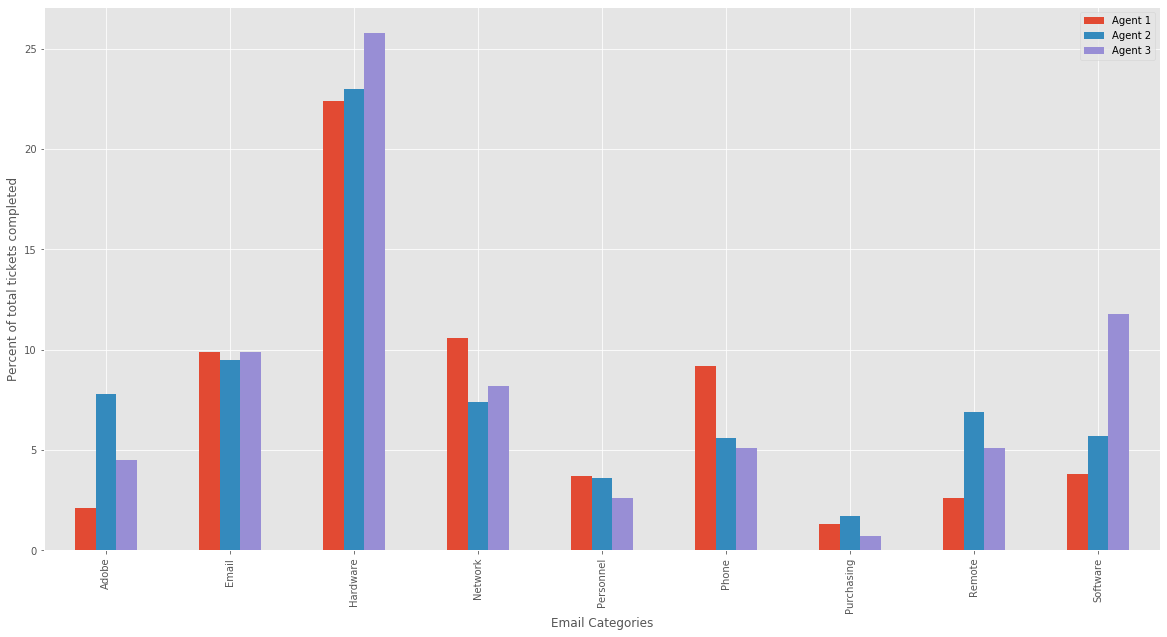

In [55]:
merged = pd.concat([Agent1,Agent2,Agent3],axis=1)
merged.columns=["From1", "Total1", "Percentage1","From2", "Total2", "Percentage2","From3", "Total3", "Percentage3"]
merged = merged.drop('',axis=0).reset_index()
ax = merged.plot.bar(x="Email Categories",y=["Percentage1","Percentage2","Percentage3"]);
ax.legend(["Agent 1","Agent 2","Agent 3"]);
ax.set_ylabel("Percent of total tickets completed");

Due to these time differences, this can give us insights about training. For instance, we see that the percentage of Network tickets, tickets with keyworks such as "internet", "wifi", "domain", "permissions", "drives", and "network drives", rises from Agent 3 and 2 to Agent 1. this shows us that with more time, agents may get more comfortable with network tickets or be asked to answer more of them. We see a similar trend with Phone tickets. On the opposite, we see a category such as hardware tickets, tickets including "station", "setup", and other computer and printer hardware words. We can see that this category gets smaller as the agents answer more tickets, this could show us that as agents are further trained, they are called upon less to answer tickets dealing with hardware. 

Overall, the categories are fairly even, showing us that although helpdesks may get more comfortable with certain types of tickets over time, **training is doing a good job of preparing new hires to deal with all types of tickets.**

***

To conclude our question about completed tickets broken down by category, we can say that we tend to complete tickets at about the same rate as we recieve them in each category. Our biggest discrepencies are in the Hardware, Software and Remote categories. We can also make conclusions about our quality of training based on this breakdown. In particular, we can say, with a small sample size, that newer hires tend to complete tickets at about the same rate across categories that more experienced technicians do. We do see an increased amount of Hardware tickets and software tickets completed by newer hires than older hires, and more network tickets completed by older hires. 



# Conclusion

### Inbox basics:

- **ADV Help has recieved 15,377 emails over the last 5 years.** This is a trend that has been growing - on average we recieve about 5 more emails every month than the last. We solve about 95 percent of tickets ($\pm5 \%$).

### When do we recieve the most tickets?:

- **Afternoons** are typically more busy than mornings. We have recieved almost 53% of our tickets in the afternoon, although that trend has changed this calendar year. In particular, we see our most emails between 9:00 and 11:00 AM and 1:00 and 3:00 PM
<br>

- **Tuesdays and Wednesdays** are our busiest days of the week. Monday afternoons are busy, while mornings have much less volume. Friday is our least busy time, both morning and afternoon. 
<br>

- Generally, **October, August and February** are times of more emails, while **December** is our least-emailed month. 

### What does our inbox breakdown look like by ticket category?:

- **About 20 percent of the total tickets we recieve are Hardware tickets, our highest category.** Email and Network tickets are next, with just over 8 percent each, then Software tickets.
<br>

- **As opposed to out total tickets, we recieve more Remote tickets in the morning**. Other categories do not see this same trend. 
<br>

- **Software tickets are growing at a faster rate than total tickets are.** We see that year by year, a higher percentage of our total tickets are software based.
<br>

- We tend to see a **spike in personnel tickets in August.** This has been a consistent trend accross the last few years.
<br>

- **We see the most email tickets in January.** This is a significant finding because January is generally one of our lowest volume times for lowest tickets. We may want to examine whether there is a reason this would be the case.
<br>

- **Purchasing tickets see a spike in September**. We should be on the lookout for more tickets involving purchasing, hardware replacements, etc. at this time of the year. 
<br>

- **We see the most network tickets on Tuesday mornings**. It is not out of the ordinary to see an increase in tickets on Tuesdays, but we know that mornings are generally less busy than afternoons. We also don't see a consistancy in increased Network tickets in the mornings, which could lead us to believe that Tuesday morning Network issues may need to be examined further. This trend is most pronounced in 2020. 


### What does our breakdown of tickets completed look like by category?:

- **We generally complete tickets at a similar rate to which we recieve them in each cateogry**. The Hardware, Remote, and Software ticket categories have the biggest discrepencies in them between recieved and completed. 
<br>

- **New hires do not have much of a difference in tickets completed by category than more experienced employees do.** We do see that (with a small sample size) new tickets complete a higher percentage of hardware and software tickets, whereas more experienced technicians complete more network tickets.

